# Stochastic Gene Expression

The expression level of a gene refers to how many biomolecules encoded by the gene are produced. If the gene encodes a functional protein, then we may like to know how many copies of this protein are produced. The biochemical processes involved in the production of biomolecules are stochastic, since at the molecular level each chemical reaction happens at a random time. Therefore, gene expression is stochastic in nature, and such stochasticity is significant for genes that are not highly expressed.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Production and degradation

We can study stochastic gene expression in the same way as for population growth. Imagine that we are interested in a gene that encodes a particular protein. The production and degradation of the protein is analogous to the birth and death of individuals in a population. For simplicity, let us assume that the protein is being produced at a constant rate, $k$. Unlike for population growth, this rate is not proportional to the number of existing members, since proteins do not self-reproduce (they are translated from mRNAs). On the other hand, the degradation rate will be proportional to the number of proteins, $N$, since each protein has the same probability of being degraded per unit time; let this degradation rate *per protein* be $\gamma$. Therefore, in a short time interval $\Delta t$, there will be about $k \Delta t$ new proteins produced, and $N \gamma \Delta t$ proteins degraded. We may expect that, at equilibrium, the production and degradation will balance out, hence the equilibrium number of proteins will be $N_{eq} = k / \gamma$. This is true only *on average*. As we have seen for population growth, the actual number will fluctuate with time. We would like to find out the range of such fluctuations.

To do that, let us simulate the stochastic processes. Denote the protein by $A$, then we can write down the reactions corresponding to the production and degradation of this protein:
\begin{align}
\emptyset &\xrightarrow{k} A \\
A & \xrightarrow{\gamma} \emptyset
\end{align}
The first reaction means the protein is being created from "nothing" at a constant rate $k$, and the second reaction means the protein is being removed at a per capita rate $\gamma$. As before, we will simulate these reactions using the Gillespie algorithm. Recall that the main idea is to draw exponentially distributed random numbers as putative times of the next event. In this case, the waiting time for the production of another protein is exponentially distributed with mean $1/k$, and that for the degradation of an existing protein has mean $1/(N\gamma)$. Which random number happens to be smaller determines which event actually happens in the simulation, i.e., whether the next event is production or degradation.

Here is a python class that simulates such a process, based on our [previous code](./birth-death.ipynb) for the birth-death process. You may notice that, besides changing variable names, we only had to change one line of the code (where `k_b` is no longer proportional to $N$).

In [2]:
class ProductionDegradation:
    """
    simulate the production and degradation of a protein using Gillespie algorithm.
    """
    
    def __init__(self, production_rate, degradation_rate=1., N0=0):
        """
        initialize the simulation.
        inputs:
        production_rate: float, overall production rate.
        degradation_rate: float, degradation rate per protein.
        N0: int, initial population size.
        """
        self.production_rate = production_rate
        self.degradation_rate = degradation_rate
        self.num = N0    # current number of proteins
        self.time = 0.    # time since beginning of simulation
        self.num_hist = [N0]    # list to record history of protein numbers
        self.time_hist = [0.]    # list to record time of all events
    
    def next_event(self):
        """
        generate the waiting time and identity of the next event.
        outputs:
        tau: float, waiting time before next event.
        event: int, 0 means production and 1 means degradation.
        """
        k_b = self.production_rate    # overall production rate, NOT proportional to number of proteins
        k_d = self.num * self.degradation_rate    # overall degradation rate
        k_d = max(k_d, 1e-10)    # if k_d is zero (when N=0), replace by a small number to avoid division by 0
        t_b = np.random.exponential(1/k_b)    # draw putative production time
        t_d = np.random.exponential(1/k_d)    # draw putative degradation time
        if t_b < t_d:    # production happens first
            event = 0    # use 0 to label production
            return t_b, event
        else:    # degradation happens first
            event = 1    # use 1 to label degradation
            return t_d, event
    
    def run(self, T):
        """
        run simulation until time T since the beginning.
        inputs:
        T: float, time since the beginning of the simulation.
        """
        while self.time < T:
            tau, event = self.next_event()    # draw next event
            self.time += tau    # update time
            if event == 0:    # production happens
                self.num += 1    # increase number of proteins by 1
            elif event == 1:    # degradation happens
                self.num -= 1    # decrease number of proteins by 1
            self.time_hist.append(self.time)    # record time of event
            self.num_hist.append(self.num)    # record protein number after event

Let us test this class. We will start from $N_0 = 0$, i.e., with no protein initially. (Such an initial value was not possible for population growth, as it means the population is already extinct.) Let us aim for an equilibrium number of proteins $N_{eq} = 100$. We can always rescale time so that the degradation rate $\gamma = 1$; then we need the production rate to be $k = N_{eq} \gamma = 100$.

In [3]:
k = 100.    # production rate
g = 1.    # degradation rate per protein
N_eq = k / g    # expected equilibrium number

In [4]:
pd1 = ProductionDegradation(k, g, N0=0)
pd1.run(10)
print(f'current time = {pd1.time}, current protein number = {pd1.num}')

current time = 10.000858598390236, current protein number = 111


As for any stochastic simulation, if we rerun the simulation, we will get a somewhat different result. To see the amount of fluctuation in the result, let us repeat the simulation multiple times and plot their trajectories.

In [5]:
T = 25.    # total amount of time to simulate
trials = 10    # number of simulations to repeat
pd_list = []    # list to store simulations

for i in range(trials):
    pd1 = ProductionDegradation(k, g, N0=0)
    pd1.run(T)
    print(f'current time = {pd1.time}, current protein number = {pd1.num}')
    pd_list.append(pd1)

current time = 25.002535015562486, current protein number = 89
current time = 25.008365291579384, current protein number = 92
current time = 25.00037835063049, current protein number = 114
current time = 25.000301532112346, current protein number = 115
current time = 25.002937393015774, current protein number = 100
current time = 25.007934515600976, current protein number = 101
current time = 25.001950258171757, current protein number = 84
current time = 25.003033945598123, current protein number = 96
current time = 25.026103730452398, current protein number = 93
current time = 25.00334911357203, current protein number = 100


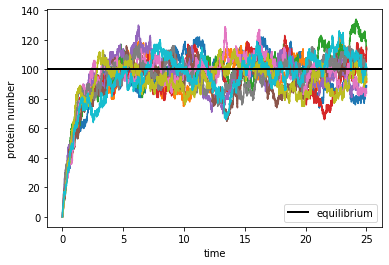

In [6]:
plt.figure()
for pd1 in pd_list:
    plt.plot(pd1.time_hist, pd1.num_hist, drawstyle='steps-post')    # stochastic realizations
plt.axhline(N_eq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
plt.xlabel('time')
plt.ylabel('protein number')
plt.legend(loc='lower right')
plt.show()

We see that, in all repeated simulations, the protein number quickly approaches the equilibrium number, then fluctuates around it. Let us characterize such fluctuation by estimating the distribution of the protein number after reaching equilibrium. From the figure we may safely consider the equilibrium to be already reached after about $t=5$. We will collect data from all repeated simulations after that time, and make a histogram of the protein number.

Note that, in our simulation, we recorded every change of the protein number. These numbers are correlated in time, as the number can only change by 1 at a time. To collect data properly, we need to first pick a set of time points that are well separated (compared to the average time between events), then retrieve the number of proteins at those chosen time points. This can be done by the following function.

In [7]:
def collect_data(time_points, time_hist, num_hist):
    """
    collect data from history of time and numbers, assuming no events happen between consecutive times in history.
    inputs:
    time_points: list (or 1-d array), time points at which to collect numbers.
    time_hist: list (or 1-d array), full history of time of events, assuming no events between times.
    num_hist: list (or 1-d array), full history of number after each event.
    outputs:
    num_points: list, collected numbers at given time points.
    """
    num_points = []    # to collect number at every time point
    if (time_hist[0] > time_points[0]) or (time_hist[-1] < time_points[-1]):   # check if data contain all time points
        raise RuntimeError('time history does not contain all time points')    # if not, report error
    for t in time_points:
        i = np.argmin(np.asarray(time_hist) <= t) - 1    # index of time point just before given time
        num_points.append(num_hist[i])    # get number at the time point
    return num_points

Now we can use this function to collect data from all simulations and look at their statistics.

In [8]:
time_points = np.arange(5, T, 0.1)    # choose time points
num_all = []    # list to collect data at given time points from all simulations
for pd1 in pd_list:
    time_hist = np.asarray(pd1.time_hist)    # convert to 1d-array
    num_hist = np.asarray(pd1.numbers_hist)    # convert to 1d-array
    num_points = collect_data(time_points, time_hist, num_hist)    # collect from each simulation
    num_all.extend(num_points)    # join the list of all data with the current new data

mean = np.mean(num_all)    # calculate the mean
print(f'mean number of proteins = {mean}')
var = np.var(num_all)    # calculate the variance
print(f'variance = {var}')
ratio = var / mean    # calculate variance-to-mean ratio
print(f'variance-to-mean ratio = {ratio}')

mean number of proteins = 98.5635
variance = 103.25096775000002
variance-to-mean ratio = 1.0475578459571748


The mean number of proteins is around $N_{eq} = 100$ as expected. The variance-to-mean ratio is very close to 1, suggesting that this may be a Poisson distribution. Let us plot a histogram of our data and see if the Poisson distribution is a good fit.

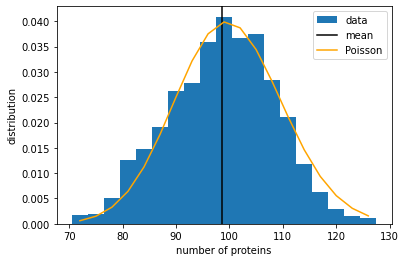

In [9]:
bins = np.arange(70.5, 130, 3)    # edges of bins (avoid integers since our data are integers)
x_array = bins[:-1] + (bins[1]-bins[0])/2    # center of bins
x_array = x_array.astype(int)    # convert to integers, for which Poisson distribution is defined
y_array = st.poisson.pmf(x_array, N_eq)    # calculate Poisson distribution with mean = N_eq

plt.figure()
plt.hist(num_all, bins=bins, density=True, label='data')    # plot histogram
plt.axvline(mean, color='k', label='mean')    # plot mean
plt.plot(x_array, y_array, 'orange', label='Poisson')    # plot Poisson distribution
plt.xlabel('number of proteins')
plt.ylabel('distribution')
plt.legend()
plt.show()

We see that the protein number does seem to follow a Poisson distribution. Indeed, it can be mathematically shown that, in this model, the equilibrium distribution of the protein number should satisfy the equation:
\begin{equation}
k P(N-1) + \gamma (N+1) P(N+1) - (k + \gamma N) P(N) = 0
\end{equation}
which has a solution:
\begin{equation}
P(N) = \frac{(k/\gamma)^N}{N!} \, \mathrm{e}^{-k/\gamma}
\end{equation}
i.e., a Poisson distribution with mean $N_{eq} = k/\gamma$. 

## Transcription and translation

Let us now consider a more general model that includes the dynamics of both the protein and the mRNA that encodes the protein (i.e., a two-stage model). There will then be four processes --- the production and degradation of both mRNA (denoted by $B$) and protein ($A$). We may assume that the production (transcription) rate of the mRNA is constant, whereas the production (translation) rate of the protein is now proportional to the number of mRNA. The degradation rate of each type of molecule is again proportional to its number. Thus, the processes involved can be represented by the reactions:
\begin{align}
\emptyset &\xrightarrow{k_1} B \\
B &\xrightarrow{\gamma_1} \emptyset \\
B &\xrightarrow{k_2} B + A \\
A &\xrightarrow{\gamma_2} \emptyset
\end{align}
Note that, in the third reaction, the mRNA $B$ acts as a "catalyst" that is present both before and after the reaction. Let the numbers of $B$ and $A$ be denoted by $M$ and $N$, respectively. Then the overall production rate of $A$ will be proportional to the total number of $B$ around, i.e., $k_2 M$. If $M$ is kept at a constant level, $M_0$, then the protein $A$ will be produced at a constant rate, $k = k_2 M_0$, as in the simpler model above. In the current model, we allow $M$ to be dynamic, so effectively the production rate of $A$ will fluctuate over time. Our goal is to see how this will affect the distribution of the protein number $N$.

### Gillespie algorithm

We will again use the Gillespie algorithm to simulate the stochastic processes described by the above reactions. Since there are two more reactions than before, we need to modify the codes for our simulation. To avoid having to customize codes every time, let us write a general purpose class for stochastic simulations using the Gillespie algorithm.

In general, consider a model that involves $n$ types of "chemical species", denoted by $S_i$ for $i = 1, \cdots, n$; they are involved in $m$ possible "chemical reactions", with rate constants $K_\mu$ for $\mu = 1, \cdots, m$. To describe each reaction, we introduce two stoichiometry matrices, $R_{\mu i}$ and $P_{\mu i}$, which contain the stoichiometric coefficients of the reactants and the products, respectively. These coefficients are usually non-negative integers. Thus, for the $\mu$-th reaction, if a species $S_i$ is not involved, then $R_{\mu i} = P_{\mu i} = 0$; else if $S_i$ is a reactant with multiplicity $p$, then $R_{\mu i} = p$; or if $S_i$ is a product of this reaction with multiplicity $q$, then $P_{\mu i} = q$. Note that some species can appear as both reactant and product (like catalysts).

Here is the general purpose code for the Gillespie algorithm, including several implementation methods (the one we have used so far is called the "first-reaction" method). It is OK if you do not understand every part of the code right now. We will simply learn how to use it for a given problem.

In [10]:
class StochSimulation:
    """
    implement Gillespie algorithm for stochastic simulation, assuming mass action kinetics.
    available methods include 'direct', 'first-reaction', and 'tau-leaping'.
    based on (D. T. Gillespie, Annu. Rev. Phys. Chem. 58, 2007).
    """

    def __init__(self, stoich, rates, init, record=True):
        """
        general purpose code for stochastic simulation using Gillespie algorithm.
        inputs:
        stoich: 2-tuple, stoichiometry matrices of reactants and products, (R_ui, P_ui), u = 1 ~ m, i = 1 ~ n
        rates: list, rate parameters, K_u, u = 1 ~ M
        init: list, initial numbers of every species, N_i(0), i = 1 ~ n
        record: boolean, whether to record full history of events
        """
        self.reactants = np.asarray(stoich[0])    # stoichiometry matrices of reactants
        self.products = np.asarray(stoich[1])    # stoichiometry matrices of products
        self.rates = np.asarray(rates, dtype=float)    # rate constant for each reaction
        self.numbers = np.asarray(init, dtype=int)    # current number of each species

        self.num_reac = self.reactants.shape[0]    # number of reactions
        self.num_spec = self.reactants.shape[1]    # number of species

        self.time = 0.                  # time since beginning of simulation
        self.nevents = 0                # total number of events that have happened
        self.term = False               # whether reactions terminated
        self.record = record            # whether to record time series

        if self.record:
            self.time_hist = [0]                  # list of times at which events happened
            self.event_hist = [-1]                # list of events that happened, -1 represents initial time
            self.numbers_hist = [self.numbers.copy()]     # list of species_number arrays right after each event


    def run(self, tmax, maxstep=10000, nmax=1000, disp=0, method='first-reaction'):
        """
        run simulation until time `tmax` since the beginning of the simulation.
        inputs:
        tmax: float, time since the beginning of the simulation.
        maxstep: int, maximum number of steps to simulate even if `tmax` is not reached.
        nmax: int, maximum number of agents of any species at which simulation stops.
        disp: int, print messages if >= 0, higher values allow more details.
        method: 'direct'|'first-reaction'|'tau-leaping', method to use.
        """
        self.term = False
        for n in range(maxstep):                # bound on number of steps
            if self.time >= tmax:               # bound on accumulated time
                return
            if np.any(self.numbers >= nmax):    # bound on number of each species
                if disp >= 0:
                    print('maximum number of agents reached.')
                return
            a_j = self.rates * np.prod(np.power(self.numbers, self.reactants), axis=1)    # mass action
            if np.all(a_j == 0):
                self.term = True    # reaction terminated
                if disp >= 0:
                    print('reactions terminated.')
                self.time = tmax    # jump to final time
                return
            elif np.any(a_j < 0):    # should not happen
                raise RuntimeError('transition rates become negative!')
            a_j = np.maximum(a_j, 1e-15)    # if a_j is zero (when N=0), replace by a small number to avoid division by 0
            if method == 'direct':  # direct method
                dn_i, tau, events = self.direct(a_j)
            elif method == 'first-reaction':  # first-reaction method
                dn_i, tau, events = self.first_react(a_j)
            elif method == 'tau-leaping':  # tau-leaping method, requires parameter tau
                tau = keywords['tau']
                dn_i, tau, events = self.tau_leap(a_j, tau)
            self.numbers += dn_i
            self.time += tau
            self.nevents += len(events)
            if self.record:
                self.time_hist.extend([self.time for ev in events])
                self.event_hist.extend(events)
                self.numbers_hist.extend([self.numbers.copy() for ev in events])
            if disp > 0:
                for i in range(len(events)):
                    ev = self.nevents - len(events) + i + 1
                    print(f'event {ev}: t = {self.time}, triggering reaction {events[i]}')
                    if disp > 1:
                        print(f'current numbers = {self.numbers}')
        else:
            if disp >= 0:
                print('maximum number of steps reached.')


    def direct(self, a_j):  # direct method
        a0 = np.sum(a_j)
        tau = -1. / a0 * np.log(np.random.rand())
        prob = a_j / a0
        event = np.random.choice(self.num_reac, p=prob)
        dn_i = self.products[event] - self.reactants[event]
        return dn_i, tau, [event]


    def first_react(self, a_j):     # first-reaction method
        tau_j = -1. / a_j * np.log(np.random.rand(self.num_reac))
        event = np.argmin(tau_j)
        dn_i = self.products[event] - self.reactants[event]
        tau = tau_j[event]
        return dn_i, tau, [event]


    def tau_leap(self, a_j, tau):   # tau-leaping method
        r_j = np.random.poisson(a_j*tau)
        dn_i = np.dot(self.products - self.reactants, r_j)
        if np.any(np.abs(dn_i) > np.maximum(1, 0.03*self.numbers)):    # check leap condition
            print('Warning: leap condition violated.')
        if np.any(self.numbers + dn_i < 0):
            raise RuntimeError('numbers become negative during tau-leaping.')
        events = np.repeat(np.arange(self.num_reac), r_j)
        return dn_i, tau, events


Given this general class (or the so-called `base class` in Python), we can define a `derived class` that is like a specific case of the general class. The derived class inherits all methods from the base class, but one can also redefine certain methods to override (or so-called "decorate") the base methods.

### 

Let us define a derived class of the base `StochSimulation` class to represent the transcription-and-translation model above. We will only modify the initialization of the class object by supplying specific stoichiometry matrices. In our model, we have $n = 2$ for the two species $S_1 = B$ and $S_2 = A$, and $m = 4$ for the four reactions with rates $K_1 = k_1$, $K_2 = \gamma_1$, $K_3 = k_2$, and $K_4 = \gamma_2$. The stoichiometry matrices corresponding to the four reactions are:
\begin{equation}
\mathbf{R} = \left( \begin{array}{cc}
0 & 0 \\
1 & 0 \\
1 & 0 \\
0 & 1
\end{array} \right) \,,
\qquad
\mathbf{P} = \left( \begin{array}{cc}
1 & 0 \\
0 & 0 \\
1 & 1 \\
0 & 0
\end{array} \right)
\end{equation}
A derived class for simulating this model can be defined as follows.

In [11]:
class TranscriptionTranslation(StochSimulation):    # it is derived from the `StochSimulation` class
    """
    simulate the transcription-and-translation model using Gillespie algorithm.
    """
    
    def __init__(self, rates, init, record=True):    # decorate base method
        """
        modify the initialization to specify the stoichiometry matrices.
        """
        reactants = [[0, 0],
                     [1, 0],
                     [1, 0],
                     [0, 1]]
        products = [[1, 0],
                    [0, 0],
                    [1, 1],
                    [0, 0]]
        StochSimulation.__init__(self, (reactants, products), rates, init, record=record)

Let us now test the class to simulate the transcription-and-translation model. We need to specify four reaction rates, mRNA production $k_1$, mRNA degradation $\gamma_1$, protein production $k_2$, and protein degradation $\gamma_2$. As before, we can set $\gamma_2 = 1$ by rescaling time, so that the average lifetime of the protein is $1/\gamma_2 = 1$. The mRNA degradation time is usually much shorter than that of proteins, i.e., $1/\gamma_1 \ll 1/\gamma_2$, so we can choose $\gamma_1 = 10$. On the other hand, mRNA usually exists in much smaller copy numbers than proteins. If we look at the mRNA part of the model (the first two reactions) alone, the math is exactly the same as for the production-and-degradation model above. Therefore, the equilibrium number of mRNA would be $M_{eq} = k_1 / \gamma_1$. We can choose $M_{eq} = 2$, so that $k_1 = 20$. At equilibrium the overall production rate of the protein will be $k = M_{eq} k_2$, so the equilibrium number of proteins will be $N_{eq} = k / \gamma_2 = M_{eq} k_2 / \gamma_2$. If we choose $N_{eq}$ to be the same as before, $N_{eq} = 100$, then we need $k_2 = 50$. Let us run our simulation with these parameter values.

In [12]:
k1 = 20.    # mRNA production rate
g1 = 10.    # mRNA degradation rate
k2 = 50.    # protein production rate
g2 = 1.     # protein degradation rate

M0 = 0    # initial number of mRNA
N0 = 0    # initial number of protein
M_eq = k1 / g1           # expected equilibrium number of mRNA
N_eq = M_eq * k2 / g2    # expected equilibrium number of protein

T = 25.    # total amount of time to simulate
trials = 10    # number of simulations to repeat
tt_list = []    # list to store simulations

for i in range(trials):
    tt1 = TranscriptionTranslation([k1, g1, k2, g2], [M0, N0], record=True)    # create simulation with given rates
    tt1.run(T, maxstep=100000)    # run simulation until time T
    print(f'current time = {tt1.time}, current numbers of mRNA and protein = {tt1.numbers}')
    tt_list.append(tt1)    # save simulation to the list

current time = 25.00400074685411, current numbers of mRNA and protein = [ 2 89]
current time = 25.00458051799042, current numbers of mRNA and protein = [ 2 83]
current time = 25.00541629813756, current numbers of mRNA and protein = [ 2 82]
current time = 25.005845490970565, current numbers of mRNA and protein = [ 0 70]
current time = 25.010554039048873, current numbers of mRNA and protein = [ 2 94]
current time = 25.008282911286155, current numbers of mRNA and protein = [ 1 98]
current time = 25.0054666602822, current numbers of mRNA and protein = [  6 114]
current time = 25.01376158688284, current numbers of mRNA and protein = [ 0 77]
current time = 25.002804714410043, current numbers of mRNA and protein = [ 4 93]
current time = 25.004647264310172, current numbers of mRNA and protein = [ 1 94]


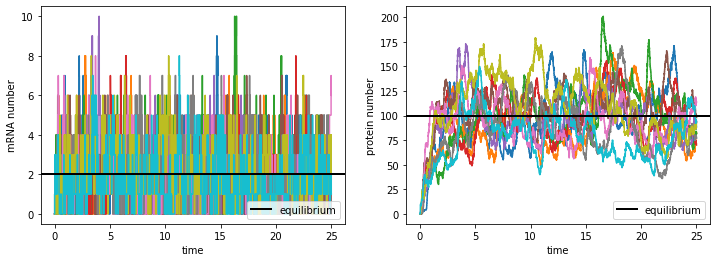

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
for tt1 in tt_list:
    time_hist = np.asarray(tt1.time_hist)    # convert to 1d-array
    num_hist = np.asarray(tt1.numbers_hist)    # convert to 2d-array, second dimension represents species
    ax[0].plot(time_hist, num_hist[:,0], drawstyle='steps-post')    # mRNA number
    ax[1].plot(time_hist, num_hist[:,1], drawstyle='steps-post')    # protein number
ax[0].axhline(M_eq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[1].axhline(N_eq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[0].set_xlabel('time')
ax[0].set_ylabel('mRNA number')
ax[0].legend(loc='lower right')
ax[1].set_xlabel('time')
ax[1].set_ylabel('protein number')
ax[1].legend(loc='lower right')
plt.show()

Comparing the right subplot with the same figure for the production-and-degradation model above, we see that in the transcription-and-translation model the protein number fluctuates much more. This is clearly because the mRNA number (left subplot) fluctuates significantly with time instead of being constant, which introduces extra stochasticity in the protein production.

Let us collect data on the protein numbers to characterize their distribution at equilibrium.

In [14]:
time_points = np.arange(5, T, 0.1)    # choose time points
prot_all = []    # list to collect protein numbers 
for tt1 in tt_list:
    time_hist = np.asarray(tt1.time_hist)    # convert to 1d-array
    num_hist = np.asarray(tt1.numbers_hist)    # convert to 2d-array, second dimension represents species
    num_points = collect_data(time_points, time_hist, num_hist[:,1])    # collect protein numbers (index 1)
    prot_all.extend(num_points)

mean = np.mean(prot_all)    # calculate the mean
print(f'mean number of proteins = {mean}')
var = np.var(prot_all)    # calculate the variance
print(f'variance = {var}')
ratio = var / mean    # calculate variance-to-mean ratio
print(f'variance-to-mean ratio = {ratio}')

mean number of proteins = 99.4655
variance = 630.64880975
variance-to-mean ratio = 6.34037741478201


We see that the mean number of proteins is still around $N_{eq} = 100$ as expected. However, from the large variance-to-mean ratio, we may conclude that this is no longer a Poisson distribution. In fact, in the limit that protein lifetime is much greater than mRNA, i.e., $\gamma_1 \gg \gamma_2$, the protein number distribution can be approximated by a negative-binomial distribution:
\begin{equation}
P(N) = {N+r-1 \choose r-1} p^r (1-p)^N
\end{equation}
where $r = k_1 / \gamma_2$ and $p = \gamma_1 /(\gamma_1 + k_2)$. This distribution can be generated by the scipy function `scipy.stats.nbinom.pmf(x, r, p)`, plotted below.

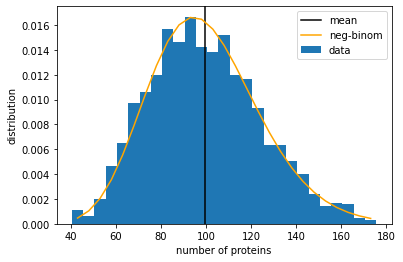

In [15]:
binwidth = 5
bins = np.arange(40.5, 180, binwidth)    # edges of bins (avoid integers since our data are integers)
hist = np.histogram(prot_all, bins=bins, density=True)[0]

x_array = bins[:-1] + binwidth/2    # center of bins
x_array = x_array.astype(int)    # convert to integers
y_array = st.nbinom.pmf(x_array, n=k1/g2, p=g1/(g1+k2))    # calculate negative-binomial distribution

plt.figure()
plt.bar(x_array, hist, width=binwidth, label='data')    # plot histogram
plt.axvline(mean, color='k', label='mean')    # plot mean
plt.plot(x_array, y_array, 'orange', label='neg-binom')    # plot negative binomial distribution
plt.xlabel('number of proteins')
plt.ylabel('distribution')
plt.legend()
plt.show()

Let us now look at the mRNA number distribution. Since the mRNA part of the model is mathematically the same as the production-degradation model above, the mRNA number should follow a Poisson distribution. Let us plot that.

In [16]:
time_points = np.arange(5, T, 0.1)    # choose time points
mRNA_all = []    # list to collect data on number of mRNA
for tt1 in tt_list:
    time_hist = np.asarray(tt1.time_hist)    # convert to 1d-array
    num_hist = np.asarray(tt1.numbers_hist)    # convert to 2d-array, second dimension represents species
    num_points = collect_data(time_points, time_hist, num_hist[:,0])    # collect mRNA numbers (index 0)
    mRNA_all.extend(num_points)

mean = np.mean(mRNA_all)    # calculate the mean
print(f'mean number of proteins = {mean}')
var = np.var(mRNA_all)    # calculate the variance
print(f'variance = {var}')
ratio = var / mean
print(f'variance-to-mean ratio = {ratio}')

mean number of proteins = 1.933
variance = 1.949511
variance-to-mean ratio = 1.0085416451112261


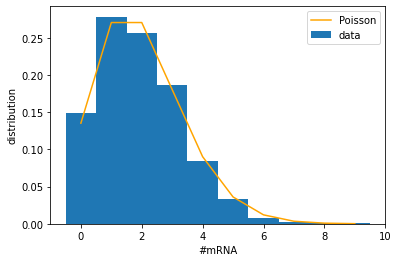

In [17]:
binwidth = 1
bins = np.arange(-0.5, 10, binwidth)    # edges of bins (avoid integers since our data are integers)
hist = np.histogram(mRNA_all, bins=bins, density=True)[0]
x_array = bins[:-1] + binwidth/2    # center of bins
x_array = x_array.astype(int)    # convert to integers
y_array = st.poisson.pmf(x_array, M_eq)    # calculate Poisson distribution

plt.figure()
plt.bar(x_array, hist, width=binwidth, label='data')
plt.plot(x_array, y_array, 'orange', label='Poisson')
plt.xlabel('#mRNA')
plt.ylabel('distribution')
plt.legend()
plt.show()

Notice that the number of mRNA is 0 about 13% of the time, during which there is no mRNA available for the translation of the protein. According to the Poisson distribution, this fraction is generally given by $P(0) = \mathrm{e}^{-M_{eq}}$ and becomes even larger for smaller $M_{eq}$. For example, if $M_{eq} = 0.5$, then mRNA is unavailable more than half of the time. In such cases, the production of proteins has to wait for episodes when the mRNA is present. Therefore, we might expect to see "bursts" of protein production from time to time, which would contribute to large fluctuations of the protein number.

Note that, the low copy number of mRNA is only one reason that could lead to bursts in protein numbers. The mRNA number itself may be subject to bursting because of intermittent production of mRNA. This phenomenon is called "transcriptional bursting", and may be due to the binding/unbinding of transcriptional factors (e.g., a three-stage model) or mechanical properties (e.g., "supercoiling") of DNA during transcription.